<a id='toc'></a>
# Отчет по запланированным поездам

1. [Проверка совпадения четности номеров поездов и направления движения](#oddity)
2. [Анализ времен стоянок поездов на станциях смены локомотивов и бригад.](#stop_time)
   1. [Анализ времен на смену локомотивов](#stop_loco)
   2. [Анализ времен на смену бригад](#stop_team)
4. [Анализ времен между отправлениями поездов со станций, выявление случаев "близкой" отправки (с интервалом меньше 5 минут)](#dep_interval)
5. [Анализ отклонения запланированного на сутки количества поездов от данных АС ССП (данные средние по суткам).](#ssp)
6. [Проверка соответствия первого участка в запланированном маршруте и исходного факта](#info_plan_depart)
6. [Создание отчета](#report)

### Функции для экспорта в HTML

In [14]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

In [15]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:        
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename, scale=0.4):
    global report
    report += ('<img src="%s" alt="%s" height="%d%%">' % (filename, filename, int(scale * 100)))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

## Загрузка и подготовка данных

In [16]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Tahoma')

pd.set_option('max_rows', 50)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv', converters={'st_from':str, 'st_to':str})
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str, 'joint':str,
                                                                 'start_st':str, 'end_st':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                     'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')
task         = pd.read_csv(FOLDER + 'task.csv', converters={'st_from':str, 'st_to':str, 'st_next':str})

st_names     = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
team_info.regions = team_info.regions.apply(literal_eval)

print('Время составления отчета:', time.strftime(time_format, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))

Время составления отчета: Jun 20, 13:53
Время запуска планировщика: Jun 09, 14:41 (1465472474)


In [17]:
def nice_time(t):
    return time.strftime(time_format, time.localtime(t))

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_norm'] = df.time_start.apply(lambda x: nice_time(x))
    if 'time_end' in df.columns:
        df['time_end_norm'] = df.time_end.apply(lambda x: nice_time(x))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    if 'oper_time' in df.columns:
        df['oper_time_norm'] = df.oper_time.apply(lambda x: nice_time(x))
    
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате
add_info(train_plan), add_info(loco_plan), add_info(team_plan)
add_info(train_info), add_info(loco_info), add_info(team_info)

# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')

# Добавляем признаки поезда и бригады (реальный/локомотиво-резервный/объемный и реальная/фейковая)
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[0])
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

# Для локомотиво-резервных и объемных поездов заполняем номер
train_plan.loc[train_plan.train_type.isin(['8', '9']), 'number'] = train_plan.train.apply(lambda x: int(str(x)[-4:]))

# Добавляем подвязанные локомотив и бригаду в таблицы loco_plan и train_plan
if 'team' not in loco_plan.columns:
    loco_plan = pd.merge(loco_plan, team_plan.loc[team_plan.state == 1, ['team', 'loco', 'time_start']], 
                         on=['loco', 'time_start'], how='left')
if 'loco' not in train_plan.columns:
    train_plan = pd.merge(train_plan, loco_plan.loc[loco_plan.state.isin([0, 1]), ['loco', 'team', 'train', 'time_start']],
                     on=['train', 'time_start'], how='left')

<a id='oddity'></a>
## Проверка совпадения четности номеров поездов и направления движения [ToC](#toc)

In [18]:
add_header('Проверки по поездам', h=1, p=False)
add_header('Проверка совпадения четности номеров поездов и направления движения', h=2, p=False)

In [19]:
train_plan['dir'] = train_plan.link.map(links.set_index('link').dir)
train_plan['odevity'] = (((train_plan.number / 2).astype(int) * 2 == train_plan.number).astype(int) + 1) % 2
train_plan['check_odd'] = train_plan.dir == train_plan.odevity
cols = ['train', 'number', 'st_from_name', 'st_to_name', 'dir', 'odevity', 'check_odd']
fail_dir_number = train_plan.drop_duplicates(subset=['train', 'number']).loc[(train_plan.train_type.isin(['8', '9'])) &
                                                          (train_plan.check_odd == False), cols]
if fail_dir_number.empty == False:
    add_header('Четность номеров поездов и направления не совпадает для %d поездов (показаны первые 10):' %
         len(fail_dir_number.index))
    pd.set_option('display.max_colwidth', 35)
    add_line(fail_dir_number.head(10))
else:
    add_line('Все четности совпадают')

Все четности совпадают


<a id='stop_time'></a>
## Анализ времен стоянок поездов на станциях смены локомотивов и бригад [ToC](#toc)

In [20]:
add_header('Проверка времен стоянок поездов на станциях смены локомотивов и бригад', h=2, p=False)

#### Параметры для анализа

In [21]:
# Минимальное время стоянки поезда для смены локомотива
min_loco_stop = 1 * 3600 # 0.5 hour = 30 min

# Минимальное время стоянки поезда для смены бригады
min_team_stop = 15 * 60 # 20 min

# Горизонт проверки
hor = 24 * 3600

<a id='stop_loco'></a>
### Смена локомотивов [ToC](#toc)

#### Поиск станций, где происходит смена локомотива c временем стоянки меньше предельно допустимого

In [22]:
cols = ['train', 'st_from_name', 'st_to_name', 'stop_time_h', 'loco', 'loco_ser', 'next_loco', 'next_loco_ser']
train_plan.loco.fillna(0, inplace=True)
train_plan.team.fillna(0, inplace=True)
train_plan['stop_time'] = train_plan.time_start.shift(-1) - train_plan.time_end
train_plan['stop_time_h'] = np.round((train_plan.stop_time / 3600), 2)
train_plan['train_end'] = train_plan.train != train_plan.train.shift(-1)
train_plan.loc[train_plan.train_end == False, 'next_loco'] = train_plan.loco.shift(-1)
train_plan.loc[train_plan.train_end == True, 'stop_time'] = -1
train_plan.loc[train_plan.stop_time != -1, 'loco_end'] = train_plan.loco != train_plan.loco.shift(-1)
train_plan.loc[train_plan.stop_time != -1, 'team_end'] = train_plan.team != train_plan.team.shift(-1)
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
train_plan['loco_ser'] = train_plan.loco.map(loco_info.drop_duplicates('loco').set_index('loco').ser_name)
train_plan['next_loco_ser'] = train_plan.next_loco.map(loco_info.drop_duplicates('loco').set_index('loco').ser_name)
no_stop = train_plan.loc[(train_plan.time_start < current_time + hor) &
               (train_plan.loco_end == True) & (train_plan.next_loco != 0) &
               (train_plan.stop_time < min_loco_stop), cols]
no_stop_n = len(no_stop.index)
no_stop_st = no_stop.st_to_name.value_counts().to_frame().join(no_stop.groupby('st_to_name').train.unique()).reset_index()
no_stop_st.columns = ['st_to_name', 'freq', 'trains']
if no_stop_st.empty == False:
    add_header('Всего %d смен локомотивов с маленькими (меньше %.2f часа) стоянками на станции смены' %
          (no_stop_n, min_loco_stop / 3600))
    add_header('Распределение по станциям смены:')
    add_line(no_stop_st.sort_values('freq', ascending=False).head(10))
    add_header('\nПримеры слишком быстрой смены локомотивов:')
    add_line(no_stop[no_stop.st_to_name == no_stop_st.ix[0].st_to_name])

#### Статистика по временам на смену локомотивов (самые "медленные" станции и самые "быстрые")

In [23]:
stop_times = train_plan.loc[(train_plan.time_start < current_time + hor) & (train_plan.next_loco != 0) &
                            (train_plan.loco_end == True) & (train_plan.stop_time != -1)]
loco_changes = stop_times.groupby('st_to_name').train.count().sort_values(ascending=False)
loco_changes.name = 'loco_changes_n'
median_stop_times = stop_times.groupby('st_to_name').stop_time.median()
median_stop_times.name = 'time_hours'
changes = median_stop_times.to_frame().join(loco_changes)
changes['time_hours'] = np.round((changes.time_hours / 3600), 2)
add_header('Всего %d станций, где локомотив всегда меняется без стоянки:' 
           % len(median_stop_times.loc[median_stop_times == 0].index))
add_line(changes.loc[changes.time_hours == 0].index.values)
add_header('\nСтанции, на которых смена локомотивов происходит дольше всего (по медианному времени):')
add_line(changes.sort_values('time_hours', ascending=False).head(10).reset_index())
add_header('\nСтанции, на которых смена локомотивов происходит быстрее всего (по медианному времени):')
add_line(changes.sort_values('time_hours').head(10).reset_index())

Всего 0 станций, где локомотив всегда меняется без стоянки:
[]

Станции, на которых смена локомотивов происходит дольше всего (по медианному времени):
  st_to_name  time_hours  loco_changes_n
    АЧИНСК I       82.76               1
         УЯР       47.43               4
 НИЖНЕУДИНСК       45.53               1
      ТАЙШЕТ       41.70               7
      АБАКАН       41.28               1
       ТЫРМА       28.46               1
    БИСКАМЖА       22.71               1
     БОГОТОЛ       20.55               1
     ТАРСКАЯ       19.57               1
 СКОВОРОДИНО       18.99               7

Станции, на которых смена локомотивов происходит быстрее всего (по медианному времени):
           st_to_name  time_hours  loco_changes_n
            УССУРИЙСК        2.52               8
          НОВЫЙ УРГАЛ        2.88               1
  КОРШУНИХА-АНГАРСКАЯ        3.57               1
                 ЛЕНА        3.77               1
              СЕЛЬГОН        5.47               1
         

<a id='stop_team'></a>
### Смена бригад [ToC](#toc)

#### Поиск станций, где происходит смена бригад c временем стоянки поезда меньше предельно допустимого

In [24]:
cols = ['train', 'st_from_name', 'st_to_name', 'stop_time', 'team', 'next_team', 'loco_end', 'team_end']
train_plan.loc[train_plan.train_end == False, 'next_team'] = train_plan.team.shift(-1)
no_stop_team = train_plan.loc[(train_plan.time_start < current_time + hor) &
                               (train_plan.team_end == True) & (train_plan.loco_end == False) &                        
                               (train_plan.next_team != 0) & (train_plan.stop_time < min_team_stop), cols]
no_stop_team_n = len(no_stop_team.index)
no_stop_team_st = no_stop_team.st_to_name.value_counts().to_frame().join(no_stop_team.groupby('st_to_name').train.unique()).\
                    reset_index()
no_stop_team_st.columns = ['st_to_name', 'freq', 'trains']
if no_stop_team_st.empty == False:
    add_header('Всего %d смен бригад с маленькими (меньше %.2f часа) стоянками на станции смены.' %
          (no_stop_team_n, min_team_stop / 3600))
    add_header('Распределение по станциям смены:')
    add_line(no_stop_team_st.sort_values('freq', ascending=False).head(10))

Всего 5 смен бригад с маленькими (меньше 0.25 часа) стоянками на станции смены.
Распределение по станциям смены:
       st_to_name  freq            trains
 ПЕТРОВСКИЙ ЗАВОД     1    [210208902481]
      ВЕРХНЕЗЕЙСК     1  [88880002774397]
        АЧИНСК II     1  [88880008514822]
  СЕВЕРОБАЙКАЛЬСК     1    [210209733921]
             БИРА     1  [88880008064563]


#### Статистика по временам на смену бригад (самые "медленные" станции и самые "быстрые")

In [25]:
team_stop_times = train_plan.loc[(train_plan.time_start < current_time + hor) & (train_plan.next_team != 0) &
                            (train_plan.team_end == True) & (train_plan.loco_end == False) & (train_plan.stop_time != -1)]
median_team_stop_times = team_stop_times.groupby('st_to_name').stop_time.median()
median_team_stop_times.name = 'time_minutes'
team_changes = team_stop_times.groupby('st_to_name').loco.count()
team_changes.name = 'team_changes_n'
median_stop_times = stop_times.groupby('st_to_name').stop_time.median()
median_stop_times.name = 'time_hours'
tchanges = median_team_stop_times.to_frame().join(team_changes)
tchanges['time_minutes'] = np.round((tchanges.time_minutes / 60), 3)
tchanges['time_hours'] = np.round((tchanges.time_minutes / 60), 3)
add_header('Всего %d станций, где бригада всегда меняется без стоянки:' %
      len(tchanges.loc[tchanges.time_minutes == 0].index))
add_line(tchanges.loc[tchanges.time_minutes == 0].index.values)
add_header('\nСтанции, на которых смена бригад происходит дольше всего (по медианному времени):')
add_line(tchanges.sort_values('time_hours', ascending=False).head(10).reset_index())
add_header('\nСтанции, на которых смена бригад происходит быстрее всего (по медианному времени):')
add_line(tchanges.sort_values('time_minutes').head(10).reset_index())

Всего 2 станций, где бригада всегда меняется без стоянки:
['АЧИНСК II' 'БИРА']

Станции, на которых смена бригад происходит дольше всего (по медианному времени):
                         st_to_name  time_minutes  team_changes_n  time_hours
                       ВЫСОКОГОРНАЯ      1080.217              18      18.004
 КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ       899.000              12      14.983
                         НОВЫЙ УОЯН       721.350               5      12.022
                        НОВЫЙ УРГАЛ       625.892               2      10.432
                          ЧЕРЕМХОВО       622.000               1      10.367
                             ЧУНОЯР       620.667               1      10.344
                               КИЖА       559.733               1       9.329
                        КОШУРНИКОВО       510.858              10       8.514
                     ЛЕНА-ВОСТОЧНАЯ       470.000               3       7.833
                             ЮКТАЛИ       443.908         

### Графики распределения времен на смену

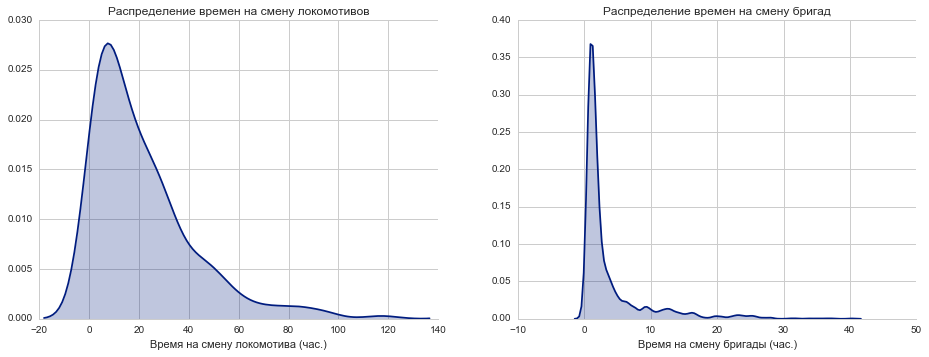

In [26]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('dark')
if (not stop_times.empty) & (not team_stop_times.empty):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    sns.distplot(stop_times.stop_time / 3600, hist=False, kde_kws={'shade':True}, ax=ax[0])
    sns.distplot(team_stop_times.stop_time / 3600, hist=False, kde_kws={'shade':True}, ax=ax[1])
    ax[0].set(xlabel='Время на смену локомотива (час.)', title='Распределение времен на смену локомотивов')
    ax[1].set(xlabel='Время на смену бригады (час.)', title='Распределение времен на смену бригад')
    sns.despine()
    fig.savefig(REPORT_FOLDER + 'changes.png', bbox_inches='tight')
    add_image('changes.png')
else:
    print('Empty dataframes: no need to plot')

<a id='dep_interval'></a>
## Поиск поездов с интервалом между отправлениями меньше допустимого [ToC](#toc)

In [27]:
add_header('Поиск поездов с интервалом между отправлениями меньше допустимого', h=2, p=False)

In [28]:
# Параметры

hor = 24 * 3600
min_time_delta = 5 * 60 # 5 minutes

In [29]:
# Функция, которая возвращает датафрейм с коллизиями

def check_time_collision(df):
    df['link_end'] = (df.st_from != df.st_from.shift(-1)) | (df.st_to != df.st_to.shift(-1))
    df['link_start'] = (df.st_from != df.st_from.shift(1)) | (df.st_to != df.st_to.shift(1))
    df.loc[df.link_end == False, 'time_to_next'] = df.time_start.shift(-1) - df.time_start
    df.loc[df.link_start == False, 'time_to_prev'] = df.time_start - df.time_start.shift(1)
    collisions = df.loc[(df.time_to_next < min_time_delta) | (df.time_to_prev < min_time_delta)]
    return collisions

In [30]:
print(time.ctime(current_time))
cols = ['train', 'loco', 'team', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm']
train_plan['train_start'] = train_plan.train != train_plan.train.shift(1)
train_plan.loc[train_plan.stop_time != -1, 'loco_start'] = (train_plan.loco != train_plan.loco.shift(1)) | \
                                                            (train_plan.train_start)
train_plan.loc[train_plan.stop_time != -1, 'team_start'] = train_plan.team != train_plan.team.shift(1)
mask = ((train_plan.loco_start == True) | (train_plan.team_start == True)) &\
        (train_plan.time_start < current_time + hor) & (train_plan.time_start >= current_time)
assign_mask = (train_plan.loco != 0) & (train_plan.team != 0)
cols_to_sort = ['st_from_name', 'st_to_name', 'time_start']
start_times = train_plan.loc[mask].sort_values(cols_to_sort)
start_times_no_res = train_plan.loc[mask & (train_plan.train_type.isin(['2', '9']))].sort_values(cols_to_sort)
start_times_real = train_plan.loc[mask & (train_plan.train_type == '2')].sort_values(cols_to_sort)
start_times_assign = train_plan.loc[mask & assign_mask].sort_values(cols_to_sort)
start_times_assign_no_res = train_plan.loc[mask & assign_mask &
                                           (train_plan.train_type.isin(['2', '9']))].sort_values(cols_to_sort)
start_times_assign_real = train_plan.loc[mask & assign_mask & (train_plan.train_type == '2')].sort_values(cols_to_sort)

all_coll = check_time_collision(start_times)
no_res_coll = check_time_collision(start_times_no_res)
real_coll = check_time_collision(start_times_real)
all_assign_coll = check_time_collision(start_times_assign)
no_res_assign_coll = check_time_collision(start_times_assign_no_res)
real_assign_coll = check_time_collision(start_times_assign_real)
train_n = len(start_times.train.drop_duplicates().index)
res = pd.DataFrame([['Все поезда', 'Без учета резервных', 'Без учета резервных и фейковых'],                    
                    [len(all_coll.index), len(no_res_coll.index), len(real_coll.index)],                    
                    [len(all_assign_coll.index), len(no_res_assign_coll.index), len(real_assign_coll.index)]]).T
res.columns = ['Тип', 'Из всех поездов', 'Из всех с подвязкой']
add_header('Количество коллизий (интервал между поездами меньше %d минут):' % (min_time_delta / 60))
add_line(res)
add_header('\nРеальные и фейковые поезда с интервалами меньше %d минут (первые 20):' % (min_time_delta / 60))
add_line(no_res_assign_coll[cols].head(20))

Thu Jun  9 14:41:14 2016
Количество коллизий (интервал между поездами меньше 5 минут):
                            Тип Из всех поездов Из всех с подвязкой
                     Все поезда             877                 697
            Без учета резервных             124                   4
 Без учета резервных и фейковых              75                   4

Реальные и фейковые поезда с интервалами меньше 5 минут (первые 20):
        train          loco          team st_from_name       st_to_name time_start_norm  time_end_norm
 220200837934  200200080358  200200107721  ПРИАМУРСКАЯ  ПОСТ-ПОКРОВСКИЙ   Jun 09, 14:45  Jun 09, 14:49
 210206403312  200200102790  200200137403  ПРИАМУРСКАЯ  ПОСТ-ПОКРОВСКИЙ   Jun 09, 14:48  Jun 09, 14:52
 210208850518  200200031713  200200272464        ХИЛОК         ЖИПХЕГЕН   Jun 10, 12:50  Jun 10, 13:20
 210209793931  200200105222  777700003119        ХИЛОК         ЖИПХЕГЕН   Jun 10, 12:50  Jun 10, 13:20


<a id='ssp'></a>
## Сравнение количества запланированных поездов с данными АС ССП [ToC](#toc)

In [31]:
add_header('Сравнение количества запланированных поездов с данными АС ССП', h=2, p=False)

In [32]:
def count_volumes(full_plan, df_ssp):
    hor = 24 * 3600
    df_ssp.dep_dir.fillna(0, inplace=True)    
    df_ssp.loc[df_ssp.dep_dir == 0, 'depart'] = 0
    df_ssp.dropna(subset=['depart'], inplace=True)
    
    ssp_st_froms = df_ssp.loc[df_ssp.dep_dir == 0].station
    mask_time = (full_plan.time_start >= current_time) & (full_plan.time_start < current_time + hor)
    mask_type = full_plan.train_type.isin(['2', '9'])
    trains = full_plan.loc[mask_time & mask_type & full_plan.st_from_name.isin(ssp_st_froms)].\
                        groupby(['st_from_name', 'st_to_name']).train.count()
    df_ssp.loc[df_ssp.dep_dir == 0, 'st_from_name'] = df_ssp.station
    df_ssp = df_ssp.fillna(method='ffill')
    df_ssp['st_to_name'] = df_ssp.station
    replace_st_from_names = df_ssp.loc[df_ssp.dep_dir == 0, ['st_from_name', 'st_show_name']].drop_duplicates()
    df_ssp['st_from_show'] = df_ssp.st_from_name.map(replace_st_from_names.set_index('st_from_name').st_show_name)
    df_ssp['st_to_show'] = df_ssp.st_show_name    
    return trains.to_frame().join(df_ssp[['st_from_name', 'st_to_name', 'depart', 'st_from_show', 'st_to_show']].\
                                  set_index(['st_from_name', 'st_to_name'])).reset_index()

In [33]:
def show_barplot(df, road_name):
    df['delta'] = df.train - df.depart
    df['percent'] = np.round(100 * df.delta / df.depart, 2)
    df['st_from_short'] = df.st_from_show.apply(lambda x: str(x)[:25])
    df['st_to_short'] = df.st_to_show.apply(lambda x: str(x)[:25])
    df['link'] = df.st_from_short + ' - ' + df.st_to_short 
    
    print('%s железная дорога:' % road_name)
    print('Среднее и медиана абсолютного отклонения: %.2f, %.2f' % (df.delta.mean(), df.delta.median()))
    print('Среднее и медиана относительного отклонения (в процентах): %.2f%%, %.2f%%' % (df.percent.mean(), df.percent.median()))

    b = df.sort_values('delta', ascending=False)
    sns.set_style('whitegrid')
    sns.set_context('poster', font_scale=0.7, rc={'axes.labelsize': 18})
    c = sns.barplot(y='link', x='delta', data=df.sort_values('delta', ascending=False), palette='coolwarm')
    xlabel = '%s ж/д: отклонение от данных АС ССП по отправлению поездов на сутки' % road_name
    c.set(xlabel=xlabel, ylabel='')

In [34]:
VOL_PERCENT = 0.9

def show_two_barplots(df, road_name, save=False, btype='less'):
    df['st_from_short'] = df.st_from_show.apply(lambda x: str(x)[:25])
    df['st_to_short'] = df.st_to_show.apply(lambda x: str(x)[:25])
    df['link'] = df.st_from_short + ' - ' + df.st_to_short     
    sns.set_style('whitegrid')    
    sns.set_context('poster', font_scale=0.7, rc={'axes.titlesize':18, 'axes.labelsize':14})
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,20))    
    df.depart.fillna(0, inplace=True)    
    df['bottom'] = df.apply(lambda row: row.depart if row.train <= row.depart else row.train, axis=1)
    df['top'] = df.apply(lambda row: row.train if row.train <= row.depart else row.depart, axis=1)     
    
    sns.set_color_codes('pastel')
    sns.barplot(x='bottom', y='link', data=df[df.train <= VOL_PERCENT * df.depart].sort_values('bottom'), 
                label='Поезда из АС ССП', color="b", orient='h', ax=ax[0])
    sns.barplot(x='bottom', y='link', data=df[df.train * VOL_PERCENT > df.depart].sort_values('bottom'), 
                label='Поезда в результатах', color="r", orient='h', ax=ax[1])
    sns.set_color_codes('muted')
    sns.barplot(x='top', y='link', data=df[df.train <= VOL_PERCENT * df.depart].sort_values('bottom'), 
                label='Поезда в результатах', color="b", orient='h', ax=ax[0])
    sns.barplot(x='top', y='link', data=df[df.train * VOL_PERCENT > df.depart].sort_values('bottom'), 
                label='Поезда из АС ССП', color="r", orient='h', ax=ax[1])    
    ax[0].legend(ncol=1, loc="upper right", frameon=True)    
    ax[1].legend(ncol=1, loc="upper right", frameon=True)
    ax[0].set(xlabel='', title='Нехватка запланированных поездов')
    ax[1].set(xlabel='', title='Избыток запланированных поездов')
    
    sns.despine()
    if save:
        filename = road_name + '.png'
        fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
        add_image(filename, scale=1.0)

Красноярская дорога


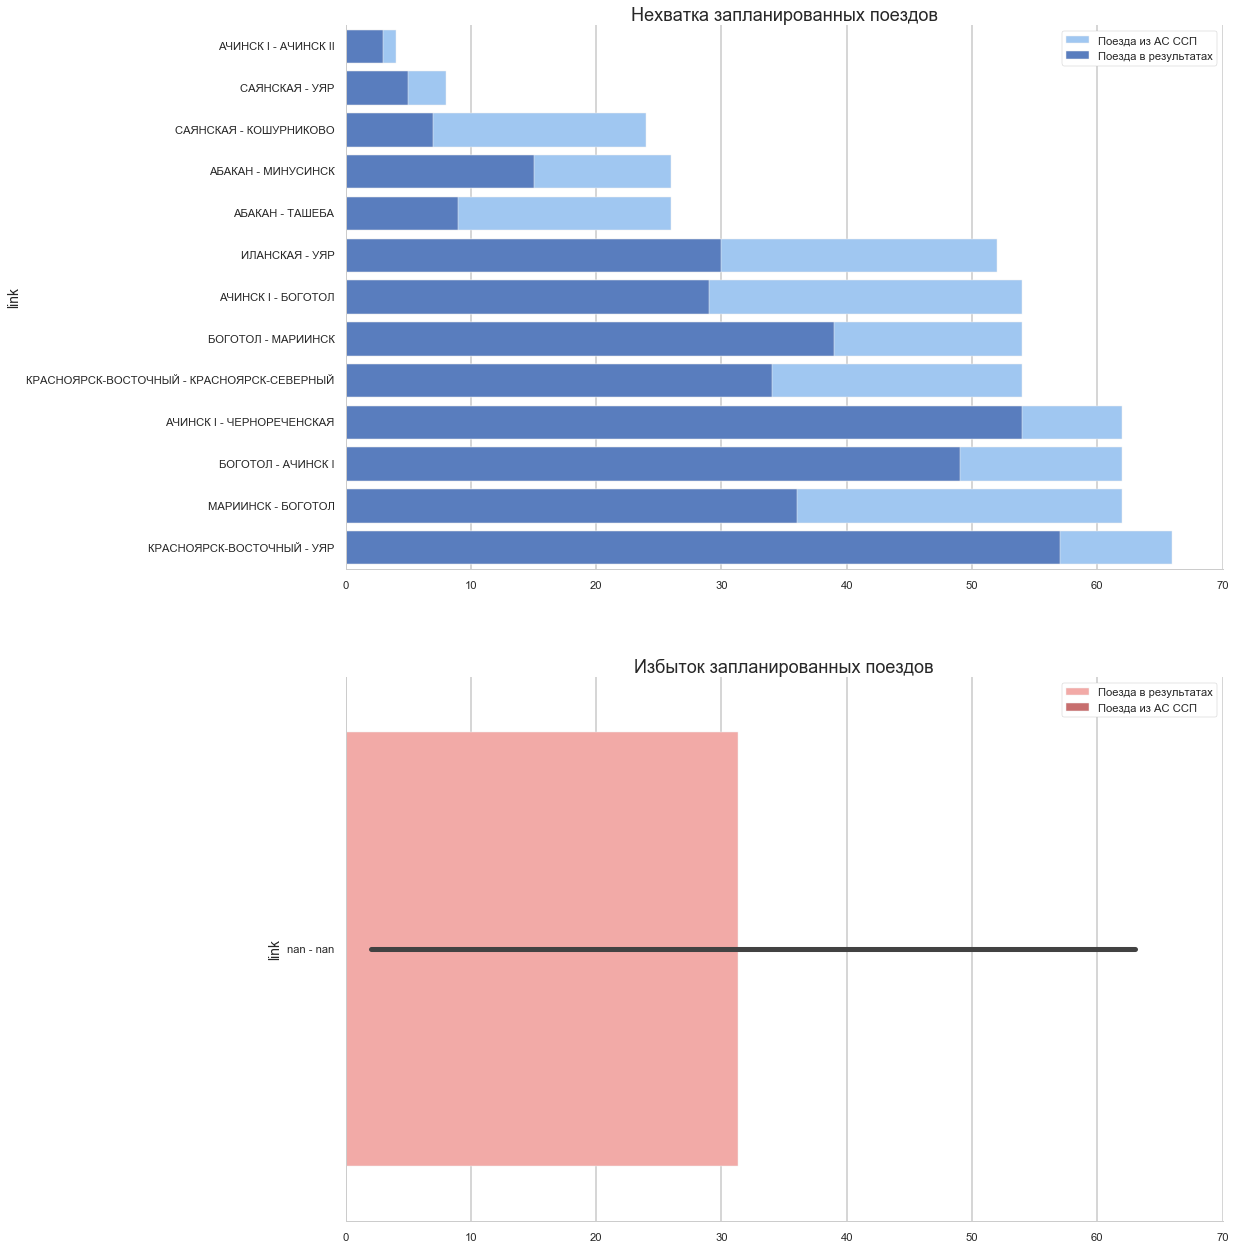

In [35]:
krs = pd.read_csv(FOLDER + 'SSP_KRS.csv', sep=';')
add_header('Красноярская дорога')
try:
    show_two_barplots(count_volumes(train_plan, krs), 'Красноярская', save=True, btype='less')
except:
    add_line('Красноярская дорога: ошибка в построении графика')

Забайкальская дорога


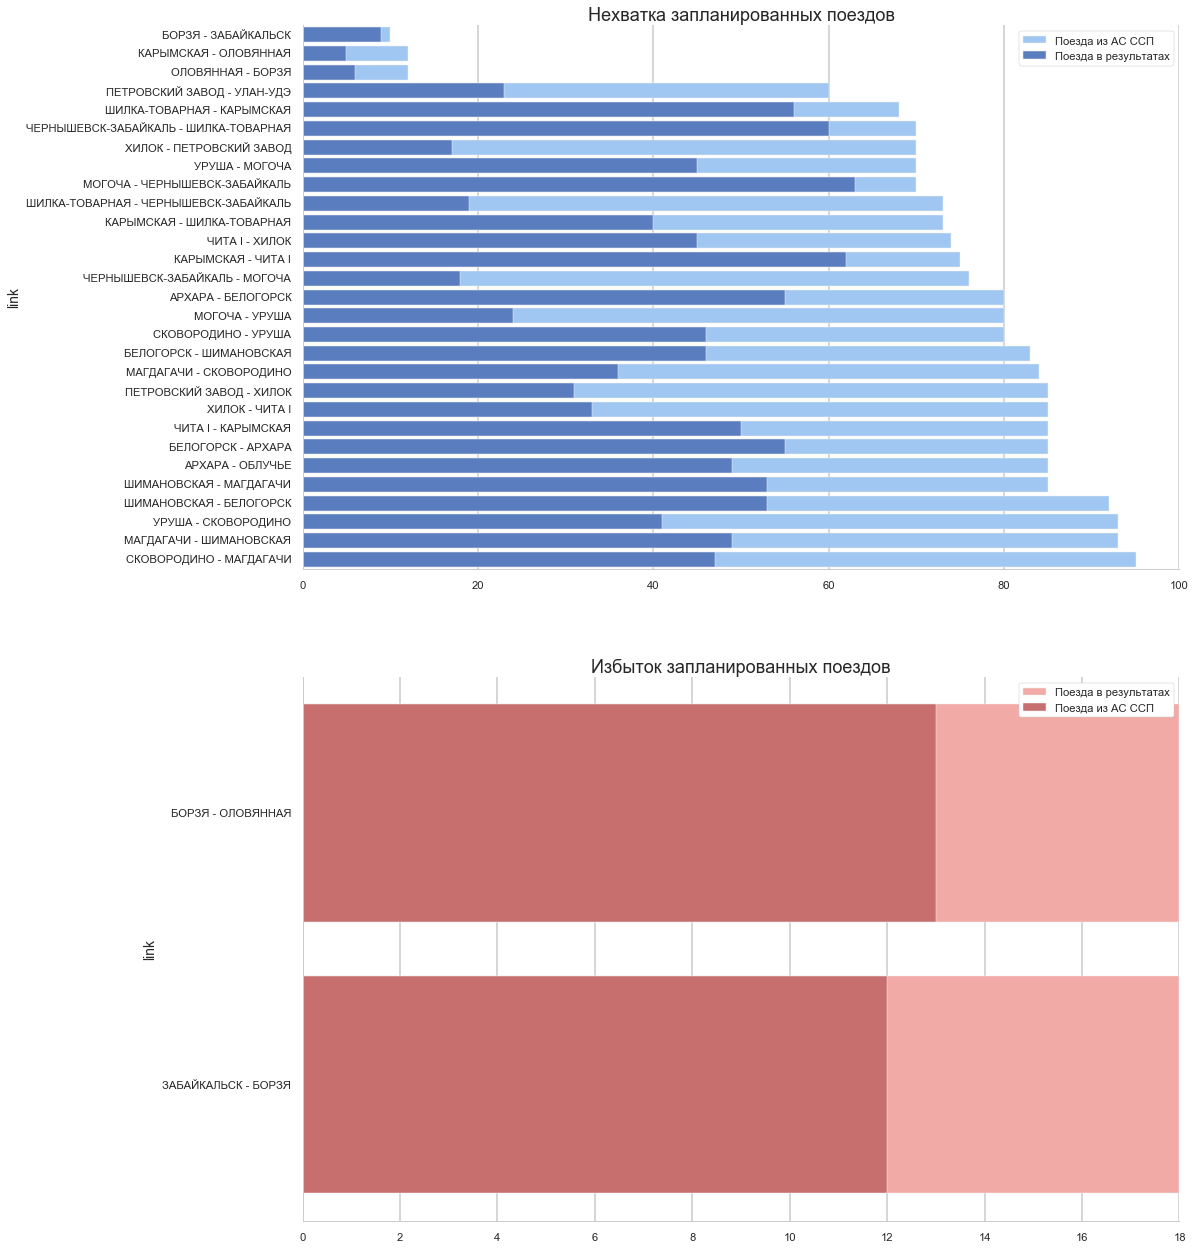

In [36]:
zab = pd.read_csv(FOLDER + 'SSP_ZAB.csv', sep=';')
add_header('Забайкальская дорога')
try:
    show_two_barplots(count_volumes(train_plan, zab).dropna(subset=['depart']), 'Забайкальская', save=True)
except:
    add_line('Забайкальская дорога: ошибка в построении графика')

Восточно-Сибирская дорога


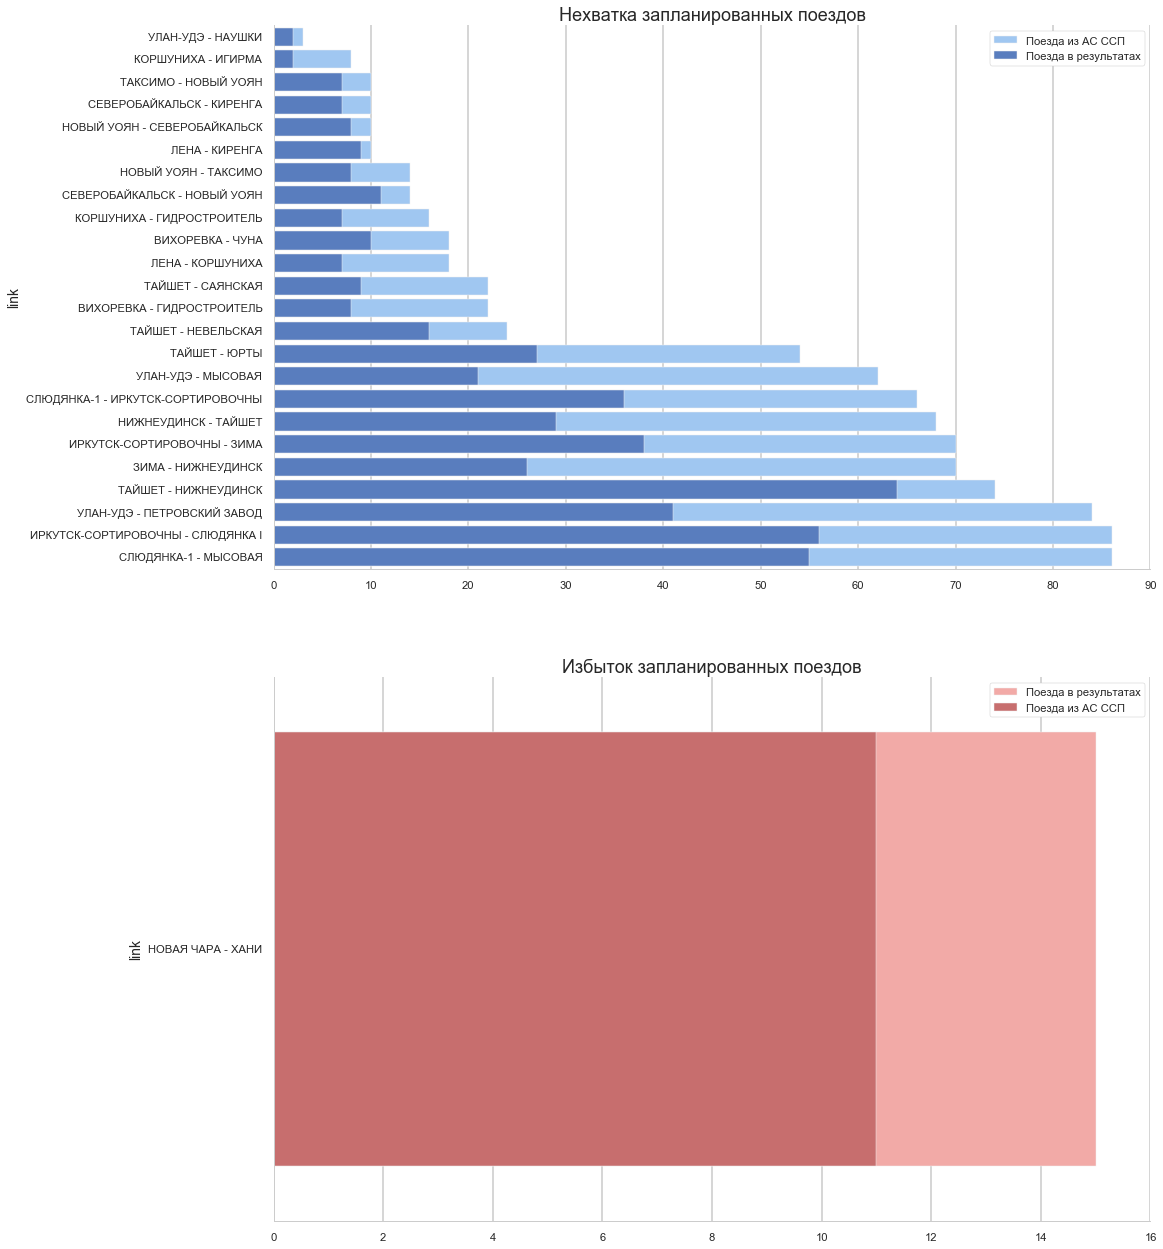

In [37]:
vsib = pd.read_csv(FOLDER + 'SSP_VSIB.csv', sep=';')
add_header('Восточно-Сибирская дорога')
try:
    show_two_barplots(count_volumes(train_plan, vsib).dropna(subset=['depart']), 'Восточно-Сибирская', save=True)
except:
    add_line('Восточно-Сибирская дорога: ошибка в построении графика')

Дальневосточная дорога


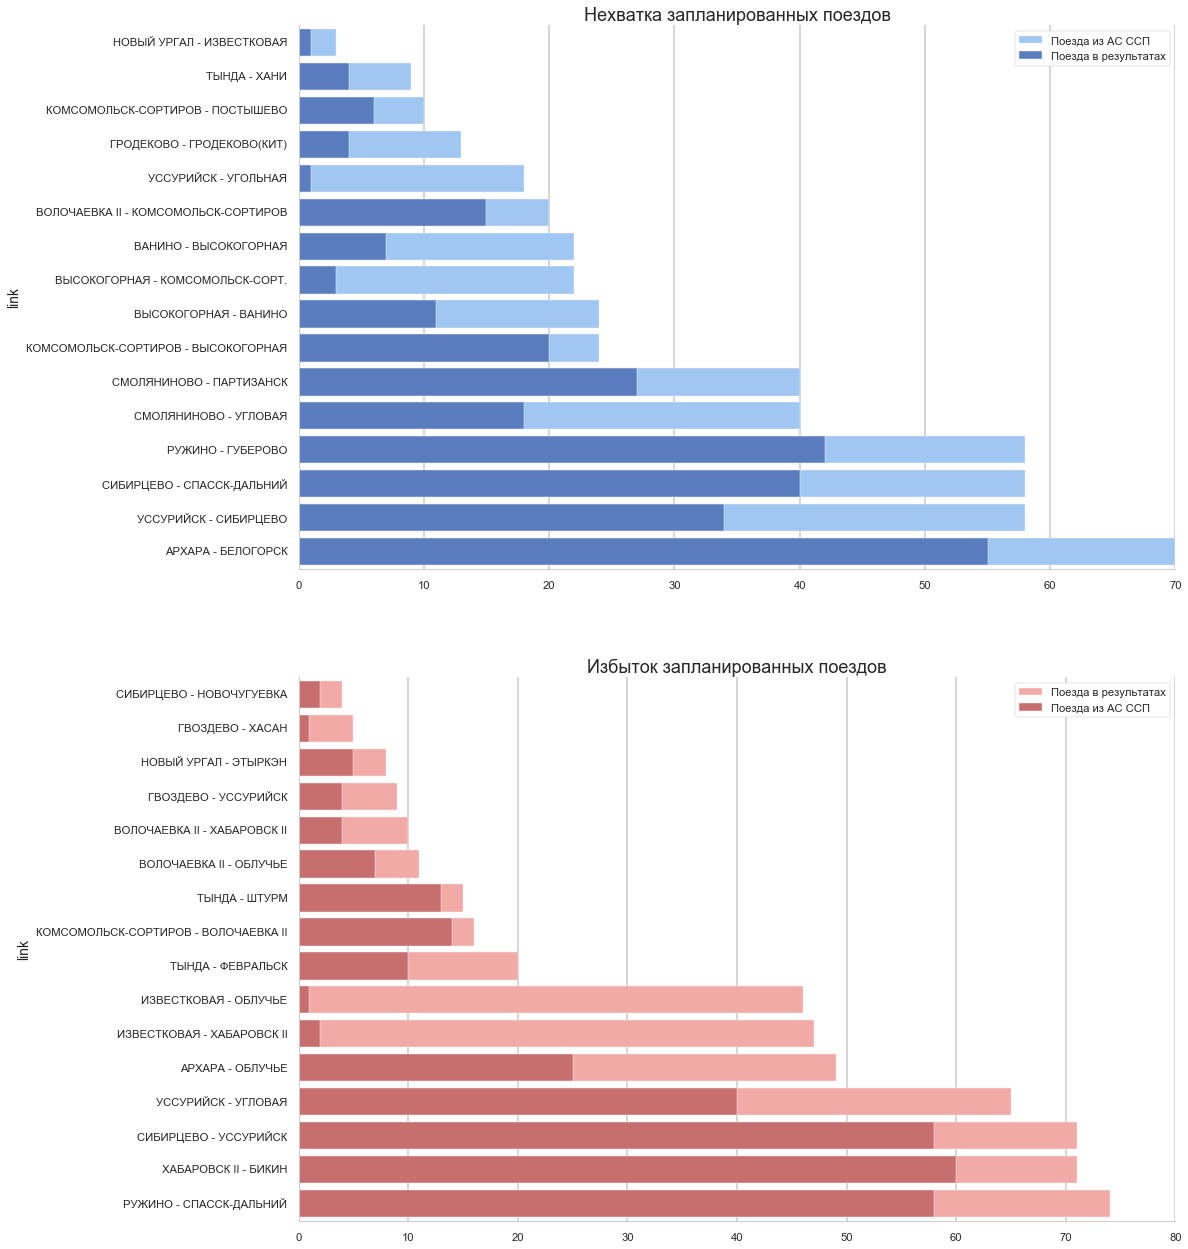

In [38]:
zab = pd.read_csv(FOLDER + 'SSP_DVS.csv', sep=';')
add_header('Дальневосточная дорога')
try:
    show_two_barplots(count_volumes(train_plan, zab).dropna(subset=['depart']), 'Дальневосточная', save=True)
except:
    add_line('Дальневосточная дорога: ошибка в построении графика')

<a id='info_plan_depart'></a>
## Проверка соответствия первого участка в запланированном маршруте и исходного факта [ToC](#toc)

In [39]:
add_header('Проверка соответствия первого участка в запланированном маршруте и исходного факта', h=2, p=False)

In [40]:
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'st_from_name_info', 'st_to_name_info', 'oper_time_norm']
td_plan = train_plan[(train_plan.st_from_info.isnull() == False) 
                     & (train_plan.st_from_info != '-1')].drop_duplicates('train')
td_bad_track = td_plan[(td_plan.st_from != td_plan.st_from_info) | (td_plan.st_to != td_plan.st_to_info)]
add_header('Поезда, у которых первый участок в маршруте не совпадает с исходным (всего %d, показаны первые 10):' 
          % td_bad_track.train.count())
add_line(td_bad_track[cols])

td_bad_time = td_plan[(td_plan.time_start != td_plan.oper_time)]
add_header('\nПоезда, у которых время отправления на первый участок в маршруте не совпадает с фактическим (всего %d, показаны первые 10):' 
          % td_bad_time.train.count())
pd.set_option('display.max_colwidth', 19)
add_line(td_bad_time.sort_values('oper_time')[cols].head(10))

Поезда, у которых первый участок в маршруте не совпадает с исходным (всего 0, показаны первые 10):
Empty DataFrame
Columns: [train, st_from_name, st_to_name, time_start_norm, st_from_name_info, st_to_name_info, oper_time_norm]
Index: []

Поезда, у которых время отправления на первый участок в маршруте не совпадает с фактическим (всего 45, показаны первые 10):
        train    st_from_name       st_to_name time_start_norm st_from_name_info  st_to_name_info oper_time_norm
 220200829834          МОГЗОН            ХИЛОК   Jun 09, 15:25            МОГЗОН            ХИЛОК  Jun 08, 21:05
 220200832349           ТУЛУН           УДА II   Jun 09, 16:10             ТУЛУН           УДА II  Jun 08, 21:41
 220200871367     СКОВОРОДИНО          ГОРЕЛЫЙ   Jun 09, 15:40       СКОВОРОДИНО          ГОРЕЛЫЙ  Jun 08, 22:52
 220200872033  ШИЛКА-ТОВАРНАЯ        СОЛНЦЕВАЯ   Jun 09, 15:55    ШИЛКА-ТОВАРНАЯ        СОЛНЦЕВАЯ  Jun 08, 23:06
 220200863247         МЫСОВАЯ         УЛАН-УДЭ   Jun 09, 16:40           

<a id='time_leaps'></a>
## Проверка скачков по времени назад [ToC](#toc)

In [41]:
add_header('Проверка скачков по времени назад', h=2, p=False)

In [42]:
train_plan['next_time_start'] = train_plan.time_start.shift(-1)
train_plan['next_time_start_norm'] = train_plan.time_start_norm.shift(-1)
train_plan['train_end'] = train_plan.train != train_plan.train.shift(-1)
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'next_time_start_norm']
leaps = train_plan[(train_plan.train_end == False) & (train_plan.next_time_start < train_plan.time_end)][cols]
if leaps.empty:
    add_header('Не найдено поездов со скачками по времени назад в плане')
else:
    add_header('Всего %d поездов со скачками по времени назад в плане. Примеры:' % leaps.train.count())
    add_line(leaps.head(10)[cols])

Всего 3 поездов со скачками по времени назад в плане. Примеры:
          train  st_from_name   st_to_name time_start_norm  time_end_norm next_time_start_norm
 88880008354631  ВОЛОЧАЕВКА I          NaN   Jun 11, 03:31  Jun 11, 05:20       Jun 11, 03:31 
 88880008354631           NaN         БИРА   Jun 11, 05:20  Jun 11, 06:07       Jun 11, 05:20 
 88880008354631          БИРА  ИЗВЕСТКОВАЯ   Jun 11, 06:07  Jun 11, 07:35       Jun 11, 06:07 


<a id='report'></a>
### Экспорт в HTML [ToC](#toc)

In [43]:
filename = REPORT_FOLDER + 'train_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/train_report_20160620_135415.html


       interval  train_num
0     (0, 1000]          0
1  (1000, 2000]        140
2  (2000, 3000]        661
3  (3000, 4000]        258
4  (4000, 5000]         48
5  (5000, 6000]          0
6  (6000, 7000]          0
7  (7000, 8000]          0
8  (8000, 9000]         51


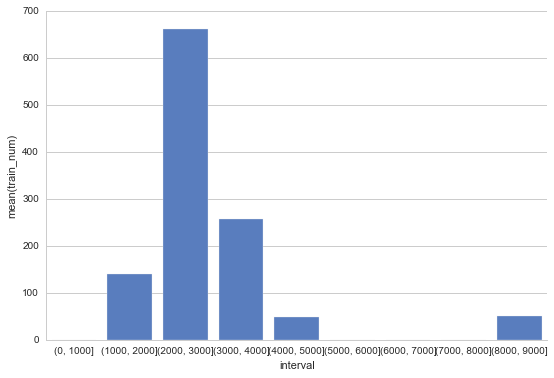

In [44]:
a = pd.cut(train_plan[train_plan.train_type == '2'].drop_duplicates('train').number,
       bins=np.arange(0, train_plan.number.max(), 1000)).value_counts().sort_index().to_frame().reset_index()
a.columns = ['interval', 'train_num']
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.barplot(x='interval', y='train_num', data=a, color='b')
sns.despine()
print(a)

In [53]:
a = train_plan.drop_duplicates('train', keep='last')
a.train_type.unique()
b = a[(a.st_to_name == 'КАРЫМСКАЯ') & (a.train_type == '2')].sort_values('time_end')[['train', 'number', 'ind434', 'st_from_name', 'st_to_name', 'time_end_norm']]
b

,train,number,ind434,st_from_name,st_to_name,time_end_norm
11766,220200729445,8505,9511-315-9431,ТАРСКАЯ,КАРЫМСКАЯ,"Jun 09, 07:38"
11613,220200355187,2900,9300-906-9431,ЧИТА I,КАРЫМСКАЯ,"Jun 09, 08:07"
44196,220201183047,8503,9447-997-9431,ТАРСКАЯ,КАРЫМСКАЯ,"Jun 09, 13:17"
71394,220200444805,2084,9300-910-9431,ЧИТА I,КАРЫМСКАЯ,"Jun 09, 14:07"
32387,220200244614,2206,9300-908-9431,ЧИТА I,КАРЫМСКАЯ,"Jun 09, 18:10"
2453,220200402648,2090,9300-909-9431,ЧИТА I,КАРЫМСКАЯ,"Jun 09, 19:01"
95290,220201341903,4301,0001-025-9431,ТАРСКАЯ,КАРЫМСКАЯ,"Jun 09, 23:57"
104844,220200134702,2501,9501-935-9431,ТАРСКАЯ,КАРЫМСКАЯ,"Jun 10, 00:50"
47936,210211663430,3001,9491-356-9431,ТАРСКАЯ,КАРЫМСКАЯ,"Jun 10, 02:42"
6719,220200315845,2575,9517-329-9431,ТАРСКАЯ,КАРЫМСКАЯ,"Jun 10, 03:09"
